In [1]:
import pandas as pd
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
# warnings.filterwarnings('ignore')

In [2]:
# Path to the new CSV file
data_file = '../data/all_sequences-v2.csv'

In [3]:
# Load all sequences and filter to Massachusetts
df = pd.read_csv(data_file)

# Filter to Massachusetts exposure
df_ma = df[df['division_exposure'] == 'Massachusetts'].copy()


print(f"\nOriginal Dataset Shape: {df.shape}")
print(f"Massachusetts-filtered Dataset Shape: {df_ma.shape}")
print(f"{df_ma.shape[0]} strains from Massachusetts")

print(f"\nSample strain names:")
print(df_ma['name'].head())

print(f"\nDate range (num_date): {df_ma['num_date'].min():.2f} to {df_ma['num_date'].max():.2f}")




Original Dataset Shape: (14761, 25)
Massachusetts-filtered Dataset Shape: (1487, 25)
1487 strains from Massachusetts

Sample strain names:
7                          USA/MA-CDC-MA1/2020
48                       USA/MA-DPH-00009/2020
53                       USA/MA_MGH_00071/2020
173              USA/MA-CDC-STM-000028441/2021
192    USA/MA-CDCBI-CRSP_NWSBNGM6I2BHDDRQ/2021
Name: name, dtype: object

Date range (num_date): 2020.08 to 2021.72


In [4]:
print("County distribution")
print(f"\nCount by county:")
print(df_ma['location'].value_counts(dropna=False))



County distribution

Count by county:
location
NaN                    1137
Barnstable County       151
Suffolk County MA        61
Middlesex County MA      40
Bristol County           34
Norfolk County           19
Plymouth County          15
Worcester County         13
Essex County MA          10
Hampden County            4
Worcester County          1
Berkshire County          1
Hampshire County          1
Name: count, dtype: int64


2021.584932 is 2021-08-02
count    1487.000000
mean     2021.447404
std         0.308872
min      2020.077869
25%      2021.532877
50%      2021.554795
75%      2021.584932
max      2021.719178
Name: num_date, dtype: float64
6318    NaN
Name: location, dtype: object


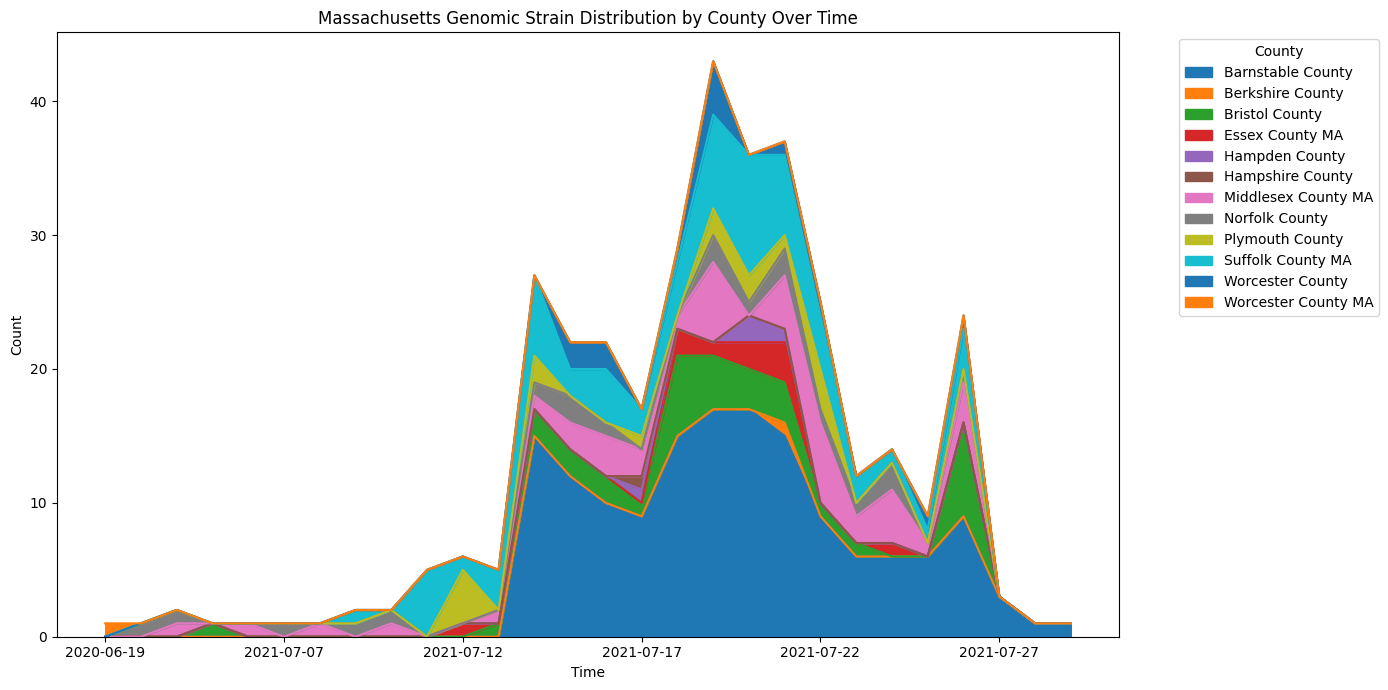

In [32]:
# Convert num_date to datetime for better visualization
# num_date is a fractional year (e.g., 2021.647945)
from datetime import datetime, timedelta

def fractional_year_to_date(fractional_year):
    # extract year and fraction
    year = int(fractional_year)
    frac = fractional_year - year
    
    # Jan 1, year
    start = datetime(year, 1, 1)
    
    # Jan 1, next year
    next_year = datetime(year + 1, 1, 1)
    # Total days in the year (accounting for leap years)
    days_in_year = (next_year - start).days
    
    # Compute actual date
    date = start + timedelta(days=frac * days_in_year)
    return date.strftime("%Y-%m-%d")

date = 2021.584932
print(f'{date} is {fractional_year_to_date(date)}')
df_ma['date'] = df_ma['num_date'].apply(fractional_year_to_date)
print(df_ma['num_date'].describe())
# Group by date and location for time series
pivot_df = df_ma.groupby(['date', 'location']).size().unstack(fill_value=0)

max_df = df_ma[df_ma['num_date'] == df_ma['num_date'].max()]
print(max_df['location'])
# Create stacked area chart
pivot_df.plot(kind='area', stacked=True, figsize=(14, 7))
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('Massachusetts Genomic Strain Distribution by County Over Time')
plt.legend(title='County', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

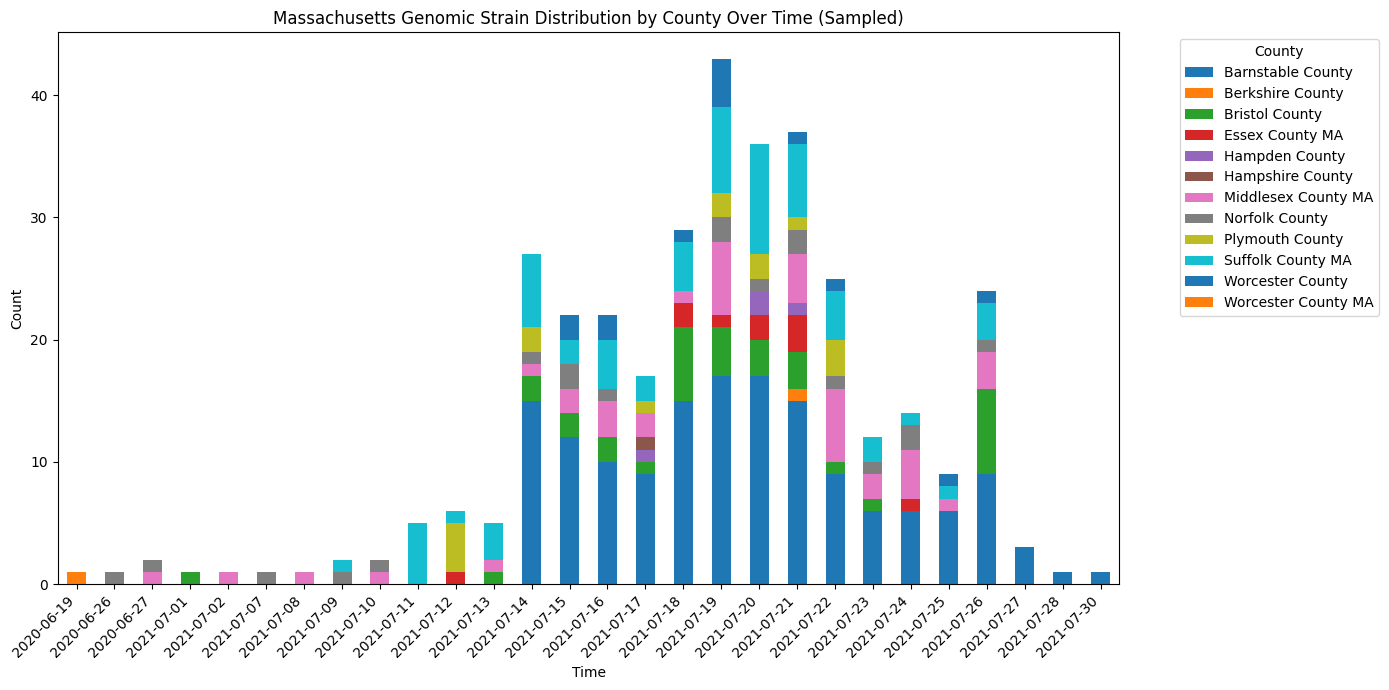

In [33]:
pivot_df.plot(kind='bar', stacked=True, figsize=(14, 7))
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('Massachusetts Genomic Strain Distribution by County Over Time (Sampled)')
plt.legend(title='County', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [35]:
# Create a pivot table: counties × clades
pivot = df_ma.pivot_table(
    index="location",  # rows (county)
    columns="nextstrain_clade",  # columns
    values="name",  # any column (we're counting)
    aggfunc="count",  # count occurrences
    fill_value=0,  # fill missing with 0
)

# Add a total column
pivot["Total"] = pivot.sum(axis=1)

# Sort by total descending
pivot = pivot.sort_values("Total", ascending=False)

# Preview
print("="*60)
print("CLADE COUNTS BY COUNTY")
print("="*60)
print(pivot.head(10))

# # Export to LaTeX
# output_file = "notes/clade_counts_by_county.tex"
# with open(output_file, "w") as f:
#     f.write(
#         pivot.to_latex(
#             caption="Counts of Nextstrain clades per Massachusetts county",
#             label="tab:clade_counts_county",
#             bold_rows=True,
#         )
#     )
# print(f"\n✓ Exported to {output_file}")

CLADE COUNTS BY COUNTY
nextstrain_clade     20A  20B  20C  20J (Gamma, V3)  21A (Delta)  Total
location                                                               
Barnstable County      0    0    0                2          149    151
Suffolk County MA      0    0    0                0           61     61
Middlesex County MA    0    0    1                0           39     40
Bristol County         0    0    0                0           34     34
Norfolk County         1    0    1                1           16     19
Plymouth County        0    0    0                0           15     15
Worcester County       0    0    0                0           13     13
Essex County MA        0    0    0                0           10     10
Hampden County         0    0    0                0            4      4
Berkshire County       0    0    0                0            1      1
